In this note we would like to explain two concepts.
* What is Bias–Variance Tradeoff
* What the __Polinomial Regression__ is. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn import datasets

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

## Simulated data

In order to have a better ilustration of the concept we are talking about in this section we are going to simulate 500s $(x_i, y_i)$ that follow the formula

$$y = 2 x^3 - x^2 + x + 1 + \varepsilon_i$$

where $\varepsilon_i$ follow normal distribution with $\mu = 0$ and $\sigma=2$.

Let's see what exactly it means.

First, we choose uniformly 1000s $x_i$ from the interval $(-2, 2)$.

In [3]:
N = 60
np.random.seed(seed=666)
x = np.random.uniform(-2, 2, N)

Next, let's generate 1000s $\varepsilon_i$ and caluculate $y_i$.

In [4]:
sigma = 2
epsilon = np.random.normal(loc=0, scale=sigma, size=N)

f = lambda x: 2 * x**3 - x**2 + x + 1
y = f(x) + epsilon

Now let's plot $x_i$, $f(x_i)$ and $y_i$.

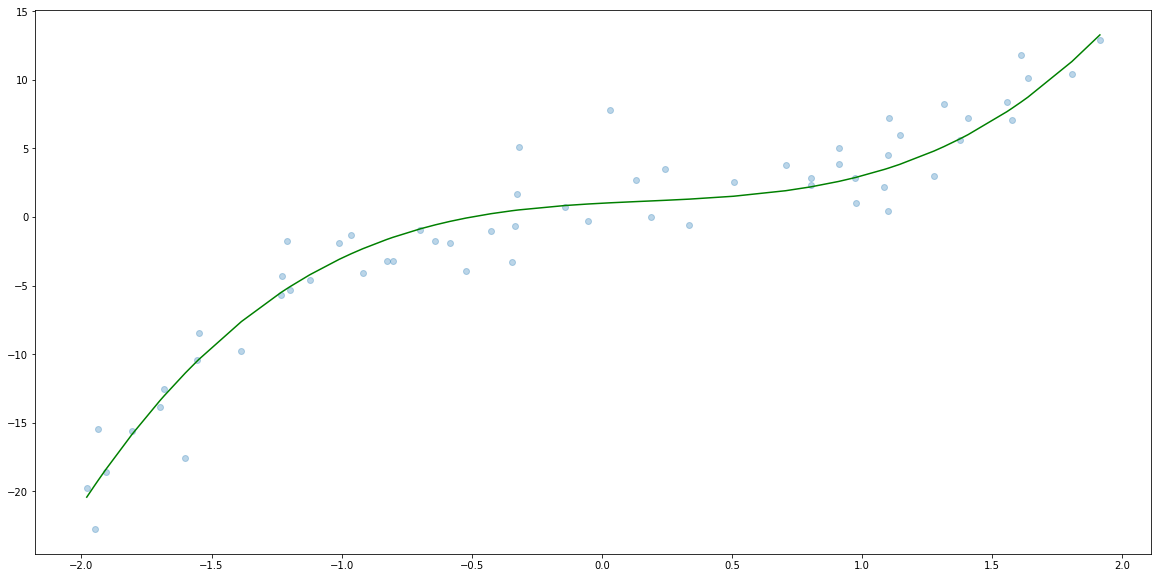

In [5]:
plt.scatter(x, y, alpha=0.3)
x_sorted = np.sort(x)
plt.plot(x_sorted, f(x_sorted), c="green")

## Model

So let's try to buld a model that predict $y_i$. That is a model 

$$y = a_1 x + a_2 x^2 + a_3 x^3 + b.$$

Of course we would expect that the trained model would have $a_1$, $a_2$, $a_3$ and $b$ as close to $1$, $-1$, $2$ amd $1$ as close as possible. 

So far we have been dealing only with linear models. So how can we build polinomial model? The answer is quite easy. 

First, we are going to create a data set that contains 3 columns $x_1=x$, $x_2=x^2$, $x_3=x^3$. Then we are actually trying to find the best model of the form

$$y = a_1 x_1 + a_2 x_2 + a_3 x_3 + b.$$

So this problem can be reduce to multilinear regression. 

### Building and trainig the model

Hence in order to train and test the model we will do the following steps.
1. Create a function that prepare data with columns $x$, $x^2$ and $x^3$
2. Split data into train and test.
3. Build a model.
4. Fit the model to train data.
5. Evaluate model on test data.

In [6]:
# 1. Create a function that prepare data with columns x, x^2 and x^3

def create_dataset_with_powers(x, max_power=3):
    x_column = np.expand_dims(x, 1) # this change vector to columns
    return np.concatenate([x_column**i for i in range(1, max_power+1)], axis=1)
 
# 2. Split data into train and test.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)
X_train = create_dataset_with_powers(x_train)
X_test = create_dataset_with_powers(x_test)

# 3. Build a model.
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# 4. Fit the model to train data.
reg.fit(X_train, y_train)

# 5. Evaluate model on test data.
from sklearn.metrics import mean_squared_error, r2_score

y_test_hat = reg.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_test_hat)))
print("R2 score: ", r2_score(y_test, y_test_hat))

RMSE:  2.3219467250684667
R2 score:  0.8864020209554593


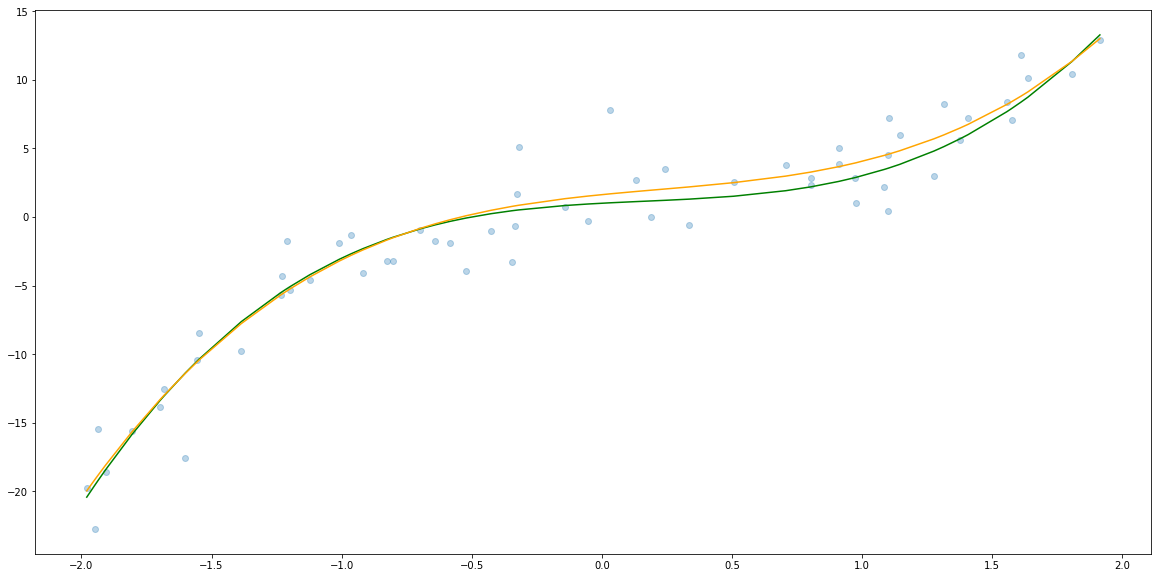

In [7]:
plt.scatter(x, y, alpha=0.3)
x_sorted = np.sort(x)
plt.plot(x_sorted, f(x_sorted), c="green")
plt.plot(x_sorted, reg.predict(create_dataset_with_powers(x_sorted)), c="orange")

And finally let's check the coeficients.

In [8]:
reg.coef_, reg.intercept_

(array([ 1.87311658, -1.16075182,  1.71730895]), 1.6260112475477435)

So not far from $1$, $-1$, $2$ amd $1$.

### How the performance depends on degree of the polynomial

Of course we know that that our model was a polynomial model with degree 3. But in general we do not know it. So how can we find out what is the degree? This is done by trainig several models with defferent degrees and test which one performs best.

__Note__ Since we use test set as a set for chosing $n$, we should do further splitinig into `train`, `dev` and `test` sets.

Therefore we are going to execute the following steps.
1. Create a function that prepare data with columns $n$ columns $x$  $x^2$ ... $x^n$ (already done)
2. Split data into train, dev and test.
3. Create a function that build polynomial model of degree $n$, fit it and report performance on dev.
4. Evaluate different models and record performance.
5. Choose best model.
6. Evaluate model on test data.

In [9]:
# 1. Create a function that prepare data with columns $n$ columns x  x^2 ... x^n 
# Already done, see function create_dataset_with_powers

# 2. Split data into train, dev and test.

x_train_dev, x_test, y_train_dev, y_test = train_test_split(x, y, random_state=666, test_size=0.2)
x_train, x_dev, y_train, y_dev = train_test_split(x_train_dev, y_train_dev, random_state=667, test_size=0.25)

# 3. Create a function that build polynomial model of degree n, fit it and report performance on dev.

def evalute_polinomial_model(degree, x_train, x_test, y_train, y_test):
    X_train = create_dataset_with_powers(x_train, degree)
    X_test = create_dataset_with_powers(x_test, degree)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_train_hat = reg.predict(X_train)
    y_test_hat = reg.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_hat)
    mse_test = mean_squared_error(y_test, y_test_hat)
    return np.sqrt(mse_train), np.sqrt(mse_test), reg

# 4. Evaluate different models and record performance.
MAX_DEGREE = 20
performance = pd.DataFrame()
regs = []

for degree in range(1, MAX_DEGREE+1):
    mses = evalute_polinomial_model(degree, x_train, x_dev, y_train, y_dev)
    new_row = pd.DataFrame({
        "degree": [degree], 
        "RMSE_train": [mses[0]],
        "RMSE_dev": [mses[1]]
    })
    performance = performance.append(new_row, ignore_index = True)
    regs.append(mses[2])
    
# 5. Choose best model.
performance.set_index("degree")

,RMSE_dev,RMSE_train
degree,,
1,4.153637,3.296009
2,3.003129,2.889720
3,2.381115,1.975418
4,2.413264,1.967882
5,2.384761,1.962849
6,2.388675,1.912717
7,2.421321,1.804209
8,2.434080,1.802891
9,2.432787,1.802520


In [10]:
# 6. Retrain the best model on both train and dev and evaluate on test data.

evalute_polinomial_model(3, x_train_dev, x_test, y_train_dev, y_test)

(2.076447010476317,
 2.4703261707591064,
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False))

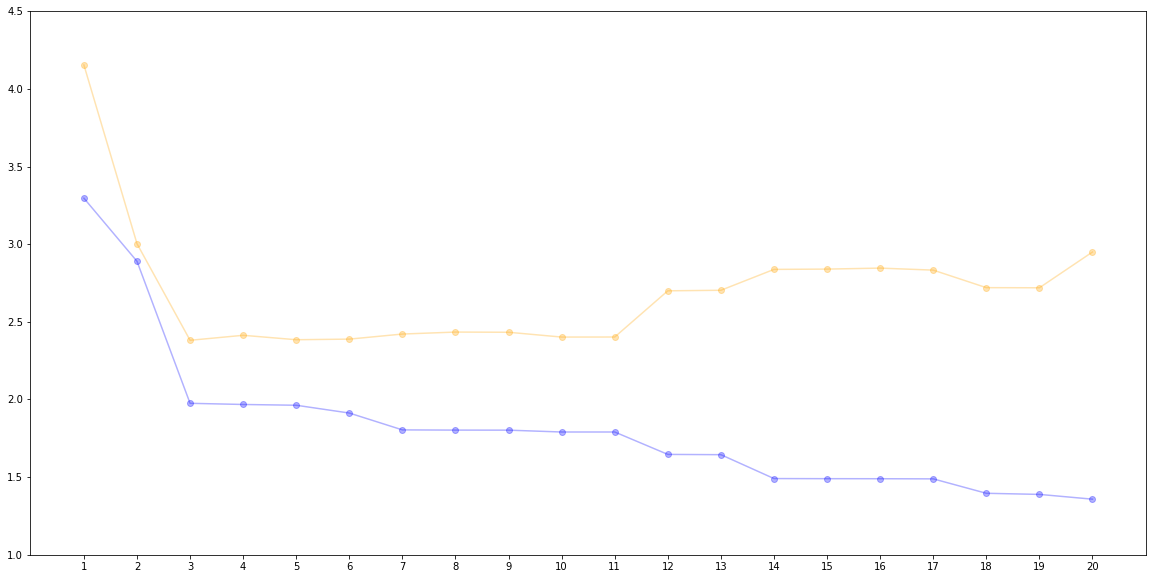

In [11]:
plt.scatter(performance["degree"], performance["RMSE_train"], alpha = 0.3, c="blue")
plt.plot(performance["degree"], performance["RMSE_train"], alpha = 0.3, c="blue")
plt.scatter(performance["degree"], performance["RMSE_dev"], alpha = 0.3, c="orange")
plt.plot(performance["degree"], performance["RMSE_dev"], alpha = 0.3,  c="orange")
plt.xticks(performance["degree"])
plt.ylim((1, 4.5))
plt.show()

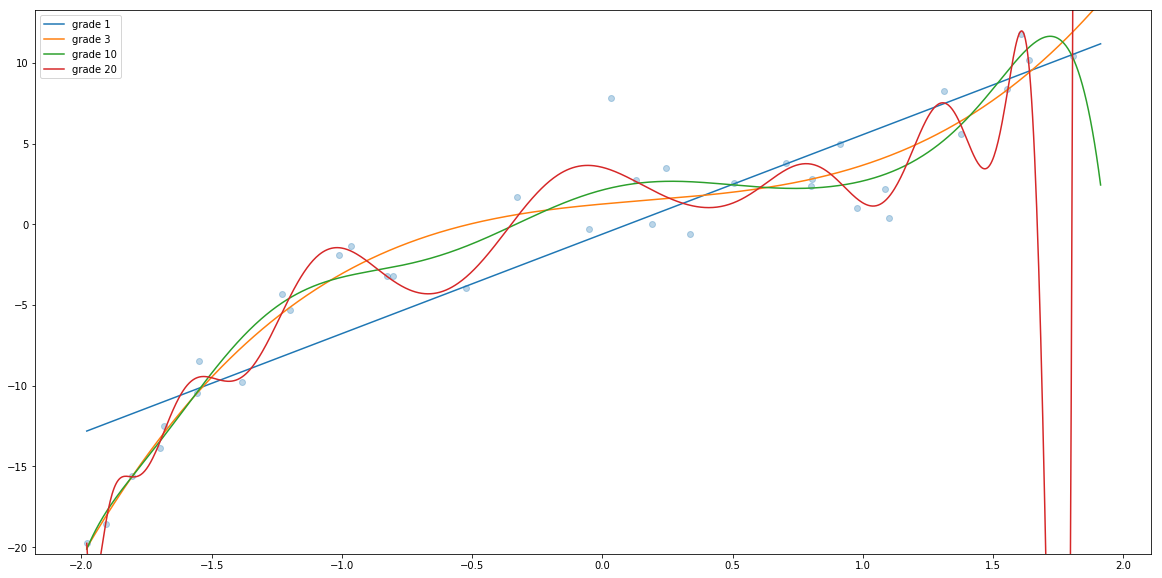

In [12]:
xs = np.linspace(np.min(x), np.max(x), num=1000)
plt.ylim((np.min(f(xs)), np.max(f(xs))))
plt.scatter(x_train, y_train, alpha=0.3)
for degree in [1, 3, 10, 20]:
    Xs = create_dataset_with_powers(xs, degree)
    ys = regs[degree-1].predict(Xs)
    plt.plot(xs, ys, alpha=1, label="grade " + str(degree))
plt.legend()

## Exercise: Boston dataset

Now let's try to analyze Boston dataset.

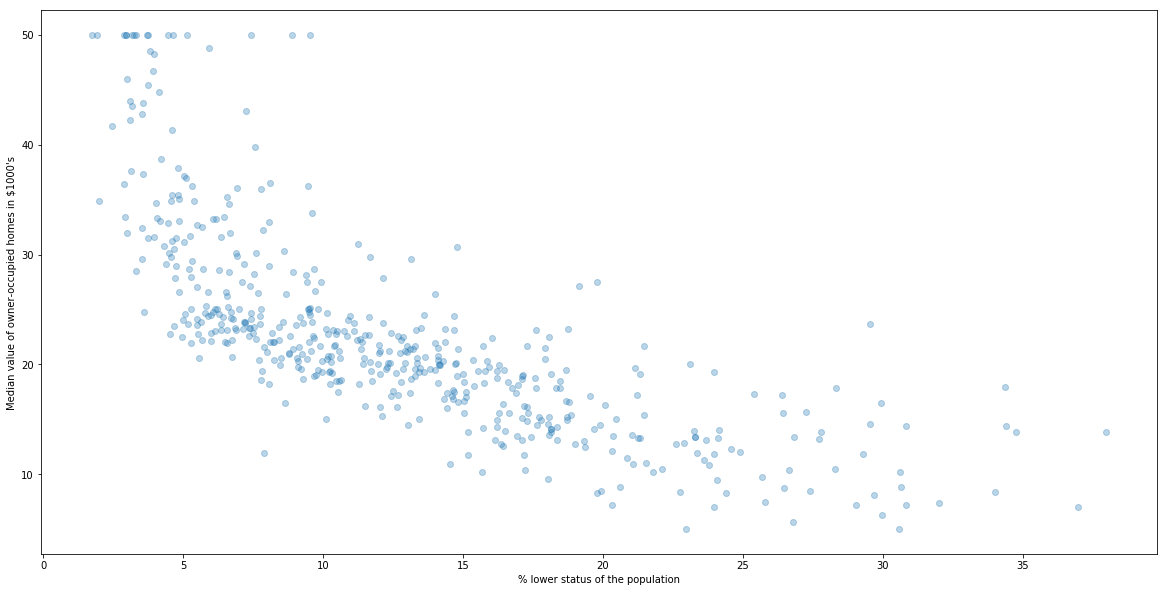

In [13]:
from sklearn.datasets import load_boston
data = load_boston()

X = data.data[:, [12]]
y = data.target

plt.scatter(X[:, 0], y, alpha=0.3)
plt.xlabel("% lower status of the population")
plt.ylabel("Median value of owner-occupied homes in $1000's")
plt.show()

There is a clear polinomial realtion. Could you find the best polinomial?

__Next__ In the next part we will explain how to evaluate classification models.
See [Machine Learning Part 5: How we evaluate classification algorithms]({% post_url 2019-02-19-Classification %})

_Updated: 2019-02-19_